# Predicting fuel consumption

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)

2.12.0


Escolha uma base de dados pública que represente um problema supervisionado de classificação ou de regressão e utilizando uma rede neural MLP de uma camada oculta:

1. escreva uma rotina que carrega a base de dados e realiza o treinamento da MLP com validação cruzada k-fold (utilize bibliotecas de aprendizado de máquina e k=5).
2. varie o número de neurônios da camada oculta buscando o melhor resultado de treinamento utilizando o algoritmo Backpropagation:
  * realize 5 inicializações do treinamento e exiba os resultados considerando o valor médio e o desvio padrão;
  * a depender do problema escolhido, o parâmetro de avaliação do desempenho pode mudar, justifique a escolha do parâmetro utilizado;
  * analise as curvas de treinamento -> em algum caso houve overfitting? Justifique.
3. com o modelo definido no item 2 (após a escolha do número de neurônios da camada oculta), refaça o treinamento modificando parâmetros do algoritmo de treinamento como: tamanho da batelada e taxa de aprendizagem.
4. com o modelo definido no item 2 (após a escolha do número de neurônios da camada oculta), refaça o treinamento modificando o algoritmo de treinamento para Levemberg-Marquardt e R-PROP.

In [2]:
# from ucimlrepo import fetch_ucirepo

# # fetch dataset
# auto_mpg = fetch_ucirepo(id=9)

# # data (as pandas dataframes)
# X = auto_mpg.data.features
# y = auto_mpg.data.targets

# # metadata
# print(auto_mpg.metadata)

# # variable information
# print(auto_mpg.variables)


## Getting data

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\darth\\.keras\\datasets\\auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

full_dataset = raw_dataset.copy()
full_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Cleaning data

In [5]:
full_dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
full_dataset = full_dataset.dropna()

In [7]:
origin = full_dataset.pop('Origin')
full_dataset['USA'] = (origin == 1)*1.0
full_dataset['Europe'] = (origin == 2)*1.0
full_dataset['Japan'] = (origin == 3)*1.0
full_dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Analyzing distribution of data.

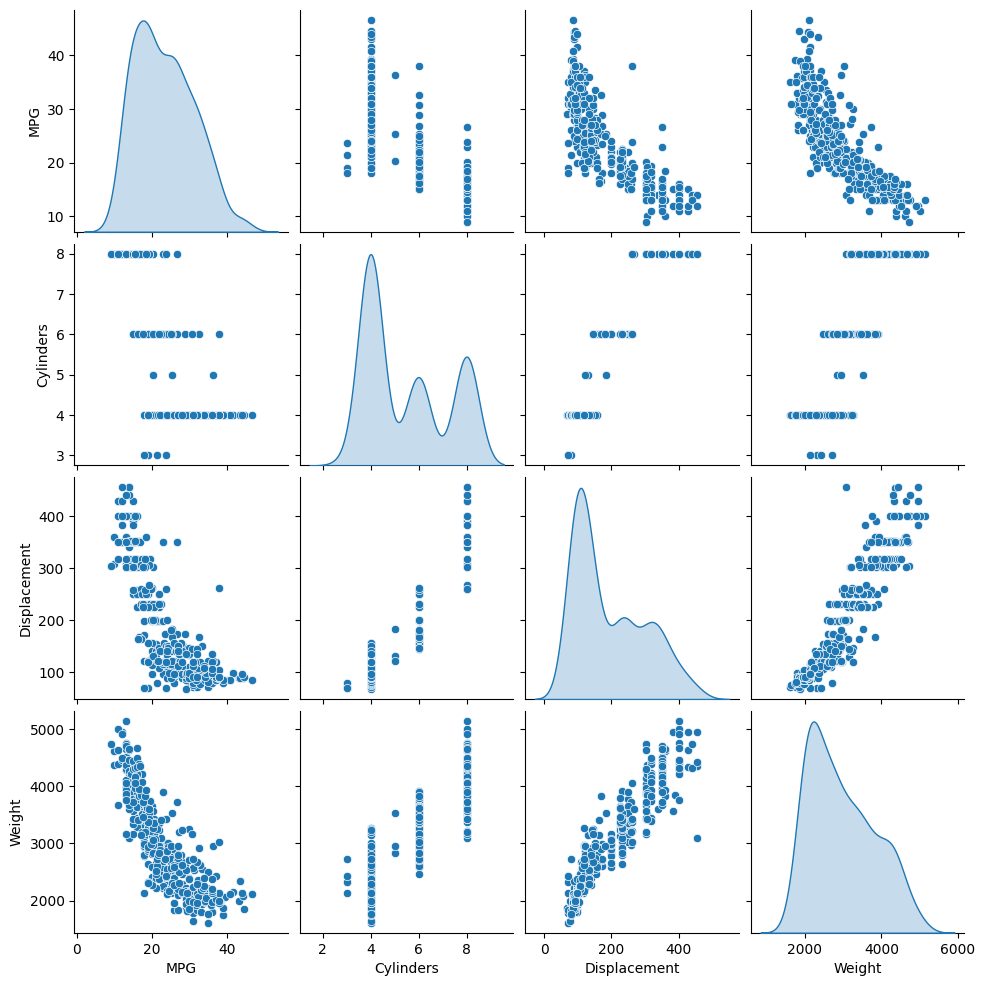

In [8]:
sns.pairplot(full_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Separating data

In [9]:
train_dataset = full_dataset.sample(frac=0.91, random_state=42)
test_dataset = full_dataset.drop(train_dataset.index)
train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

X = train_dataset
y = X.pop('MPG')

X_test = test_dataset
y_test = X_test.pop('MPG')

print(len(train_dataset))
print(len(test_dataset))

357
35


In [10]:
train_dataset.reset_index()

,index,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,0,4,96.0,69.0,2189.0,18.0,72,0.0,1.0,0.0
1,1,4,121.0,115.0,2795.0,15.7,78,0.0,1.0,0.0
2,2,4,91.0,60.0,1800.0,16.4,78,0.0,0.0,1.0
3,3,4,91.0,70.0,1955.0,20.5,71,1.0,0.0,0.0
4,4,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
352,352,4,98.0,66.0,1800.0,14.4,78,1.0,0.0,0.0
353,353,4,97.0,60.0,1834.0,19.0,71,0.0,1.0,0.0
354,354,4,79.0,70.0,2074.0,19.5,71,0.0,1.0,0.0
355,355,6,232.0,90.0,3211.0,17.0,75,1.0,0.0,0.0


In [11]:
stats = X.describe()
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,357.0,5.504202,1.718410,3.0,4.0,4.0,8.0,8.0
Displacement,357.0,196.429972,105.772151,68.0,105.0,151.0,302.0,455.0
Horsepower,357.0,105.739496,39.232409,46.0,76.0,95.0,130.0,230.0
Weight,357.0,2993.198880,856.067539,1613.0,2228.0,2830.0,3630.0,5140.0
Acceleration,357.0,15.470868,2.753811,8.0,13.6,15.5,17.0,24.8
Model Year,357.0,75.932773,3.685832,70.0,73.0,76.0,79.0,82.0
USA,357.0,0.621849,0.485606,0.0,0.0,1.0,1.0,1.0
Europe,357.0,0.173669,0.379357,0.0,0.0,0.0,0.0,1.0
Japan,357.0,0.204482,0.403889,0.0,0.0,0.0,0.0,1.0


In [12]:
def norm(x):
  stats = x.describe()
  stats = stats.transpose
  mean = stats['mean']
  std = stats['std']

  return (x - mean) / std

# normed_train_data = norm(dataset)

## Model

In [13]:
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

In [14]:
def get_model(neurons=10, input_shape=None):
    model = keras.models.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(neurons, activation='relu'),
        # tf.keras.layers.Dropout(0.2),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='Adam',
                  loss="mse",
                  metrics=['mae', r2_metric])
    return model

## Cross validation KFold

In [15]:
def make_dataset(X_data, y_data, n_splits):
    def gen():
        for train_index, test_index in KFold(n_splits).split(X_data):
            # Use `.iloc` se X_data ou y_data forem pandas DataFrame/Series
            X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
            y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]
            yield X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy()

    return tf.data.Dataset.from_generator(gen, (tf.float64, tf.float64, tf.float64, tf.float64))

dataset = make_dataset(X, y, 5)
dataset

<_FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

In [16]:
type(dataset)

tensorflow.python.data.ops.flat_map_op._FlatMapDataset

In [17]:
for fold, (X_train, y_train, X_val, y_val) in enumerate(dataset):
    print(f"Fold {fold + 1}:")
    print(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"  X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print()

Fold 1:
  X_train shape: (285, 9), y_train shape: (285,)
  X_val shape: (72, 9), y_val shape: (72,)

Fold 2:
  X_train shape: (285, 9), y_train shape: (285,)
  X_val shape: (72, 9), y_val shape: (72,)

Fold 3:
  X_train shape: (286, 9), y_train shape: (286,)
  X_val shape: (71, 9), y_val shape: (71,)

Fold 4:
  X_train shape: (286, 9), y_train shape: (286,)
  X_val shape: (71, 9), y_val shape: (71,)

Fold 5:
  X_train shape: (286, 9), y_train shape: (286,)
  X_val shape: (71, 9), y_val shape: (71,)



## Training

In [18]:
def train_kfold(dataset, neurons=5, epochs=30):
    models_hist = {}
    final_metrics = {}
    models = []

    for fold, (X_train, y_train, X_val, y_val) in enumerate(dataset):
        input_shape = X_train.shape[1:]  # Exclude the batch size

        model = get_model(input_shape=input_shape, neurons=5)
        print(f"Training fold number {fold}.")
        hist = model.fit(
            x=X_train, y=y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            verbose=0
        )

        # Saving model, history, and metrics
        models_hist[f'model_{fold}'] = hist
        models.append(model)
        print(model)
        for metric, values in hist.history.items():
            if metric not in final_metrics:
                final_metrics[metric] = []
            final_metrics[metric].append(values[-1])

    return models, models_hist, final_metrics

# models, models_hist, final_metrics = train_kfold(dataset)

In [19]:
# print("We will visualize:", list(models_hist['model_0'].history.keys()))

Plotting all the metrics

In [20]:
def plot_metrics(history_dict):
    # Separating training and validation metrics
    metrics = [key for key in history_dict.keys() if not key.startswith("val_")]
    val_metrics = ["val_" + metric for metric in metrics]
    
    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(4 * num_metrics, 3))

    if num_metrics == 1:
        axs = [axs]

    for i, metric in enumerate(metrics):
        sns.lineplot(data=history_dict[metric], label='Training ' + metric, ax=axs[i])
        sns.lineplot(data=history_dict[val_metrics[i]], label='Validation ' + metric, ax=axs[i])

        # Personalize each subplot
        axs[i].set_title(f"{metric.capitalize()} Over Epochs")
        axs[i].set_xlabel("Epoch")
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend()

    plt.tight_layout()
    plt.show()


# for history in models_hist:
#     history_dict = models_hist[history].history
#     plot_metrics(history_dict)

In [21]:
# print("Final Metrics (Mean ± Std):")
# for metric, values in final_metrics.items():
#     mean = np.mean(values)
#     std = np.std(values)
#     print(f". {metric}: {mean:.4f} ± {std:.4f}")

### Training with diferrent neurons

In [22]:
neurons_choices = [5, 10, 15, 25, 50]

Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


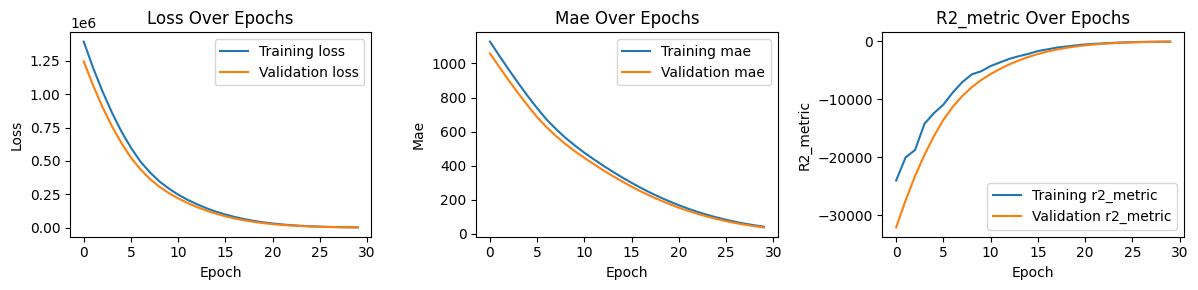

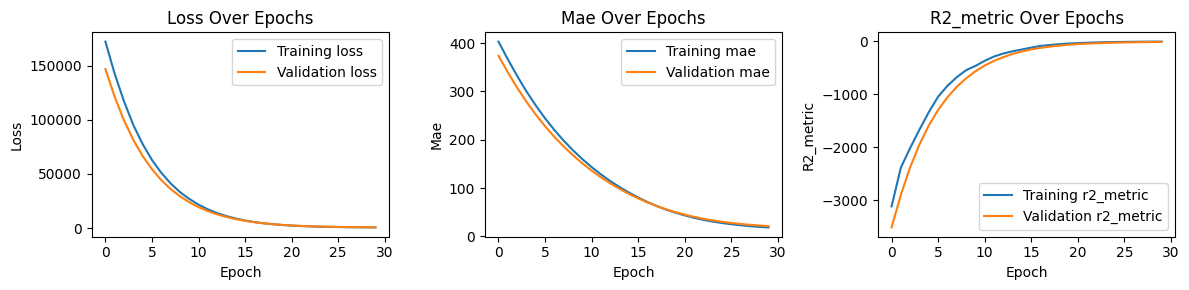

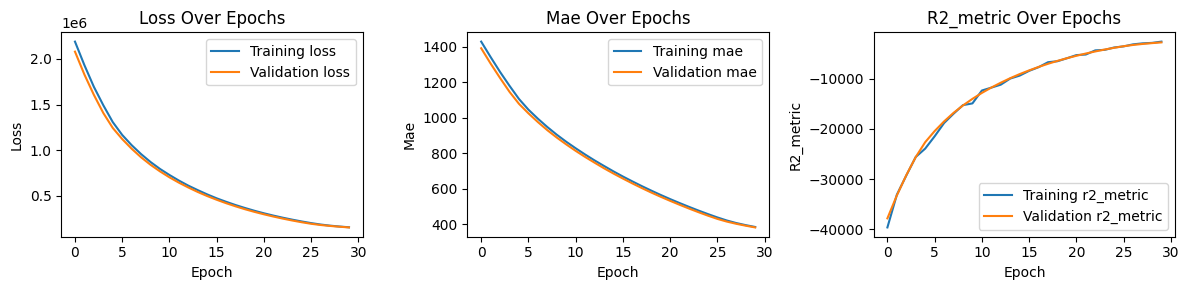

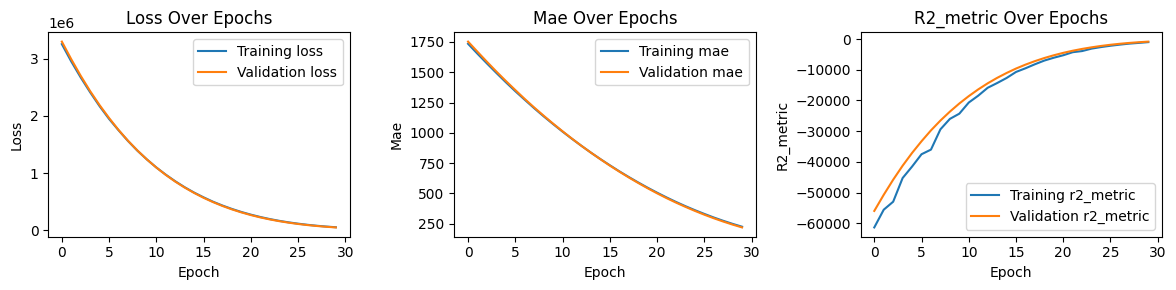

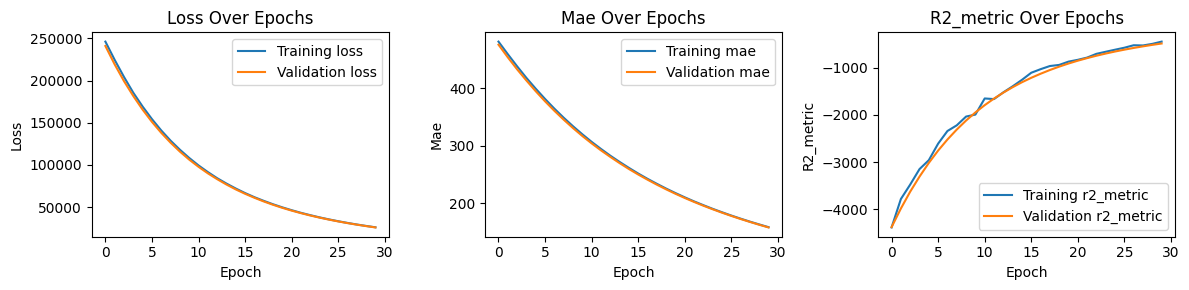

Final Metrics (Mean ± Std):
. loss: 47348.8087 ± 56991.6315
. mae: 165.8138 ± 132.4968
. r2_metric: -826.8864 ± 977.1768
. val_loss: 46284.3115 ± 56322.3608
. val_mae: 163.7087 ± 131.3301
. val_r2_metric: -835.9801 ± 1028.1413
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


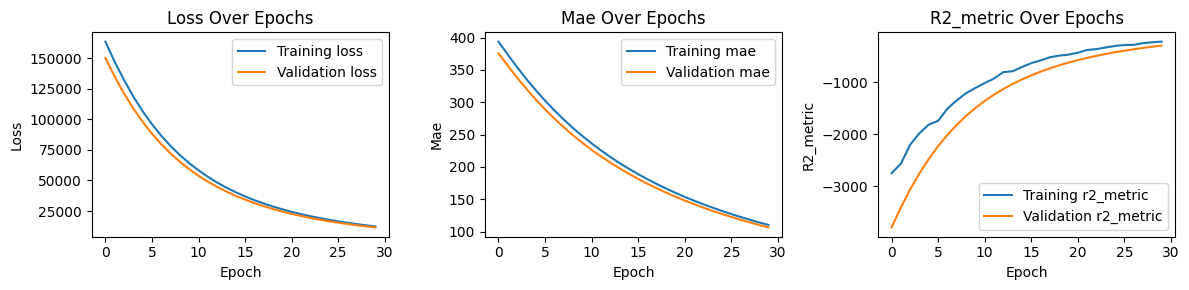

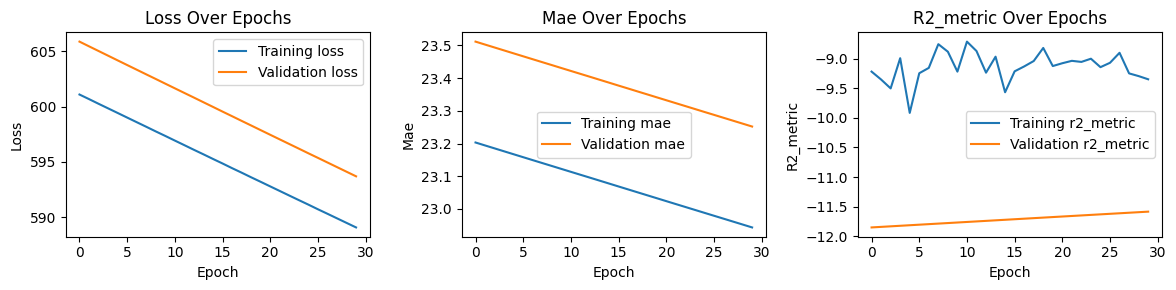

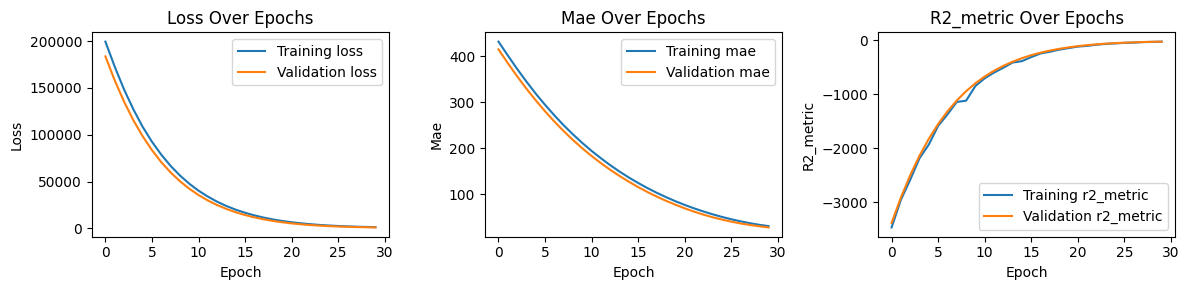

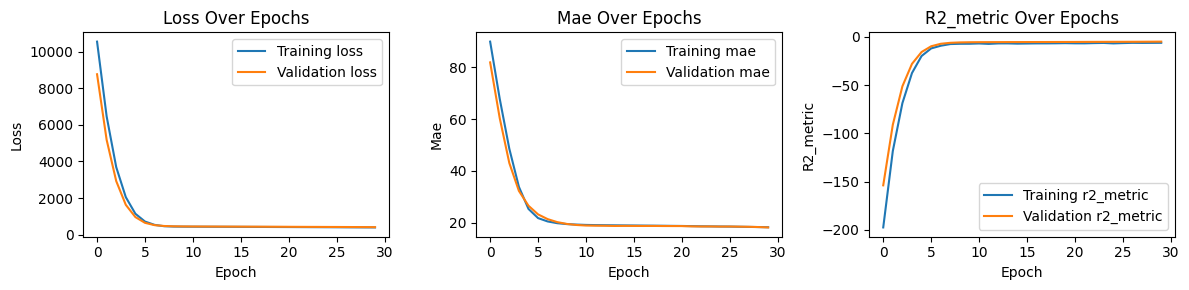

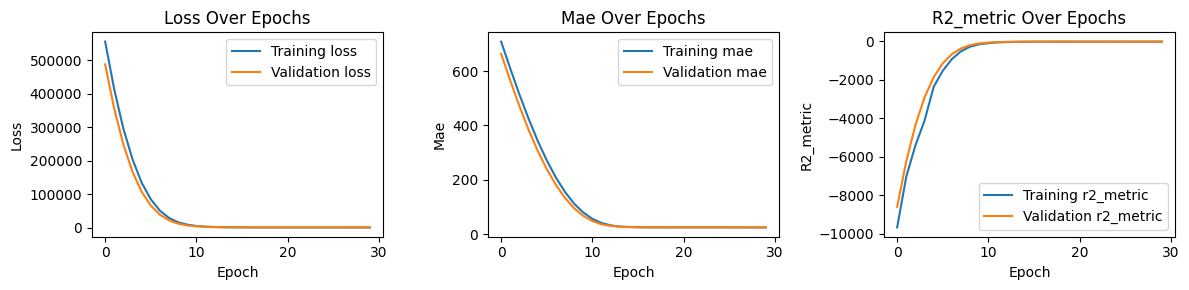

Final Metrics (Mean ± Std):
. loss: 3103.6426 ± 4658.2183
. mae: 41.4885 ± 34.6051
. r2_metric: -52.7919 ± 80.1775
. val_loss: 2904.9720 ± 4351.9088
. val_mae: 40.2275 ± 33.2432
. val_r2_metric: -68.7666 ± 110.6036
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


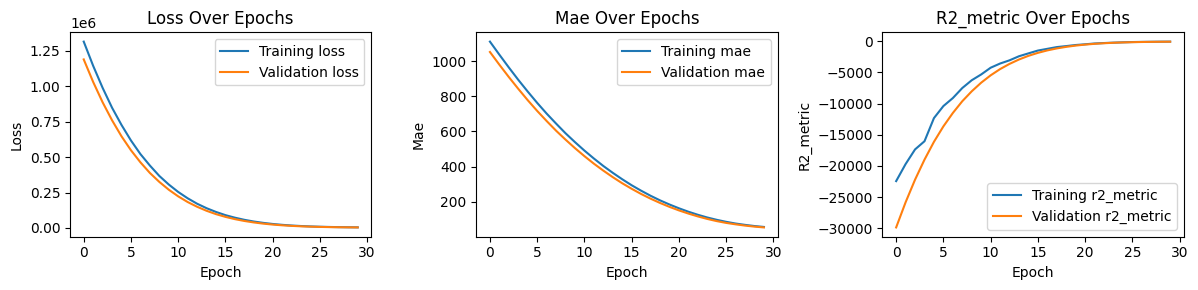

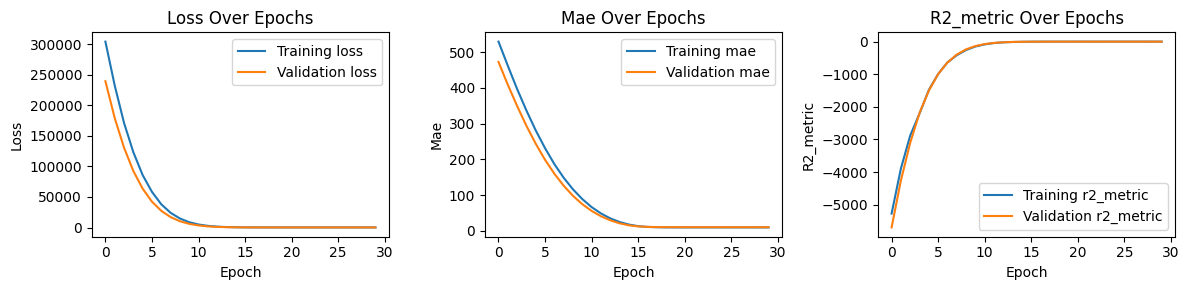

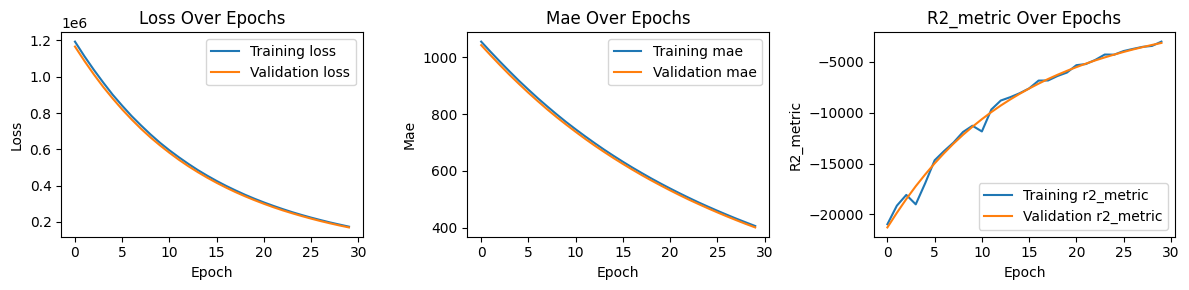

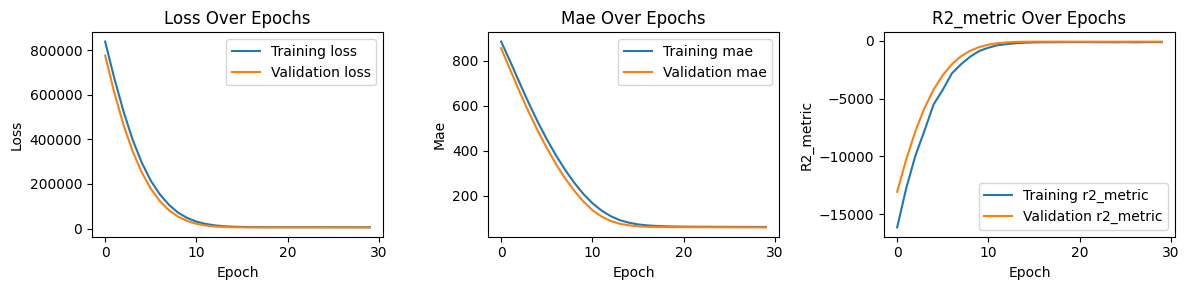

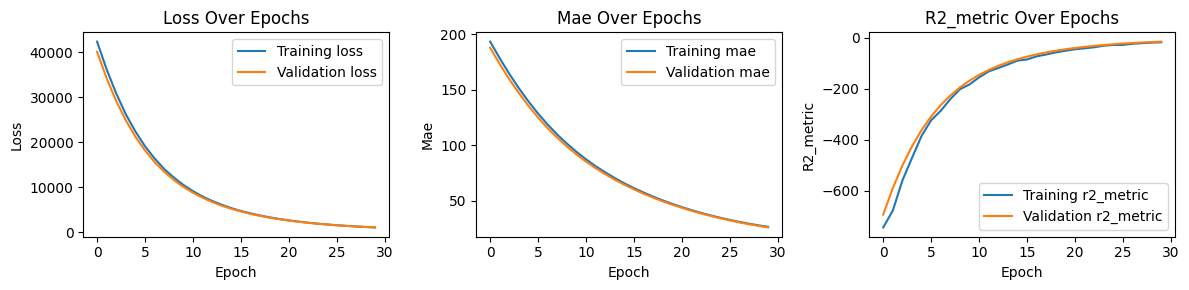

Final Metrics (Mean ± Std):
. loss: 37162.7375 ± 68550.7894
. mae: 112.0596 ± 148.2400
. r2_metric: -642.9914 ± 1183.2429
. val_loss: 36018.4117 ± 66984.7255
. val_mae: 110.1162 ± 146.5771
. val_r2_metric: -661.9523 ± 1238.5629
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


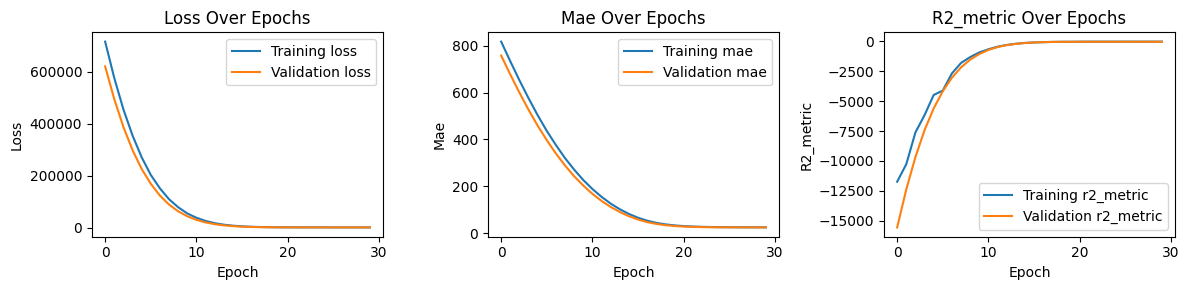

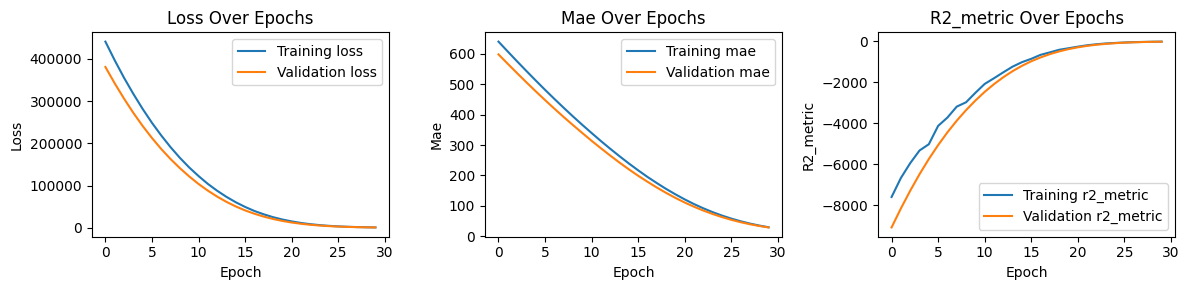

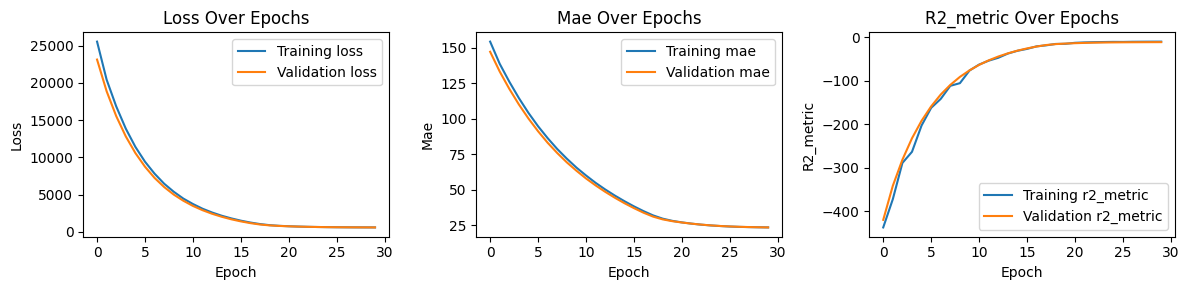

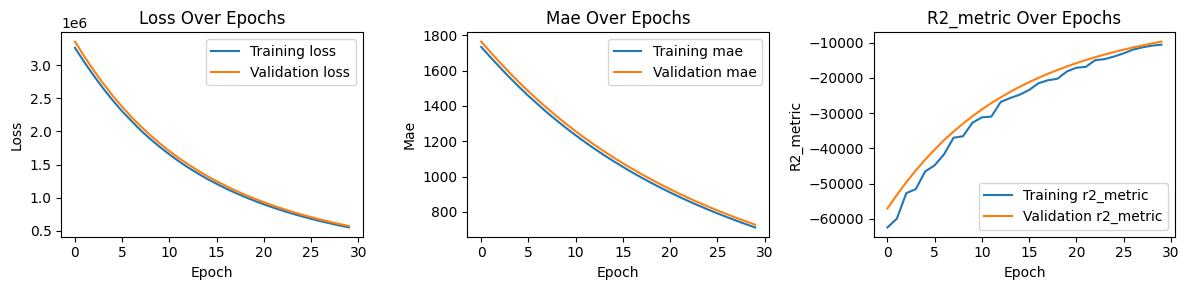

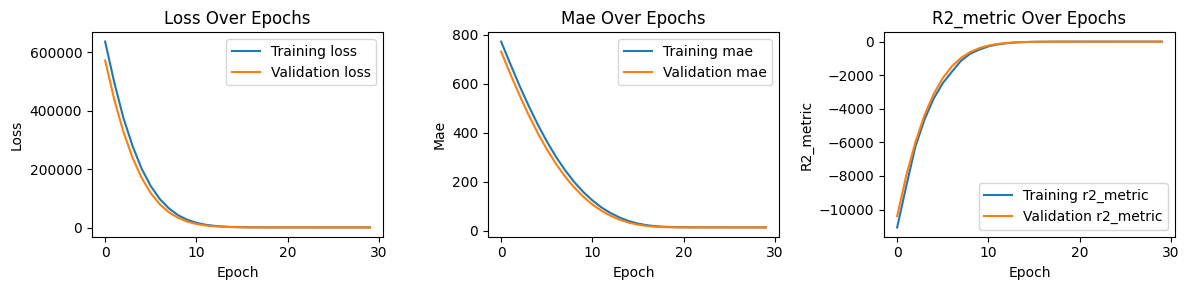

Final Metrics (Mean ± Std):
. loss: 110840.1410 ± 220116.0065
. mae: 160.9915 ± 275.3663
. r2_metric: -2127.7939 ± 4231.2724
. val_loss: 114939.8542 ± 228439.8123
. val_mae: 163.8452 ± 281.6570
. val_r2_metric: -1958.9422 ± 3884.9454
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


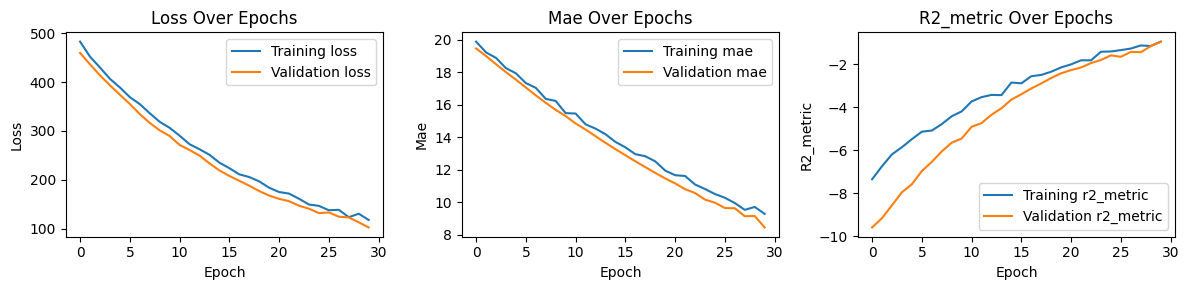

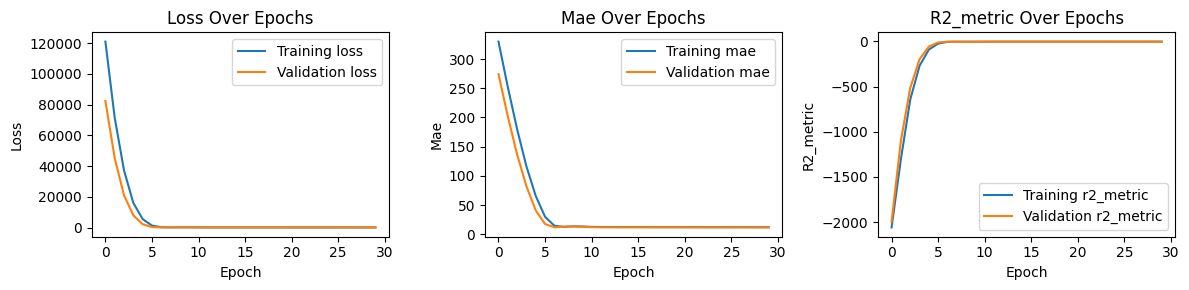

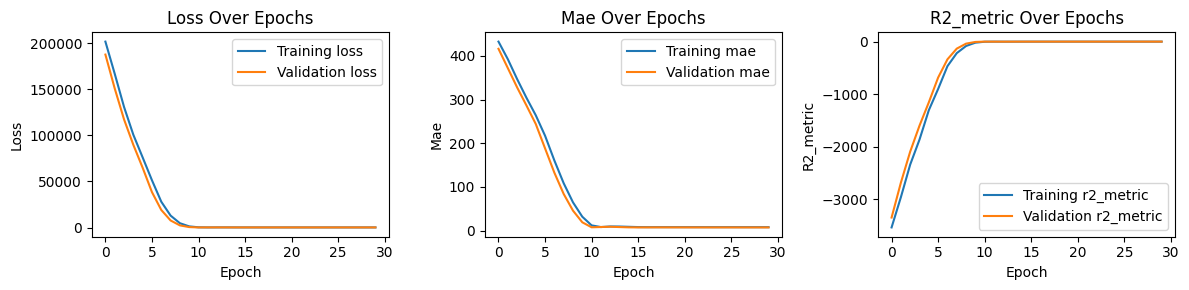

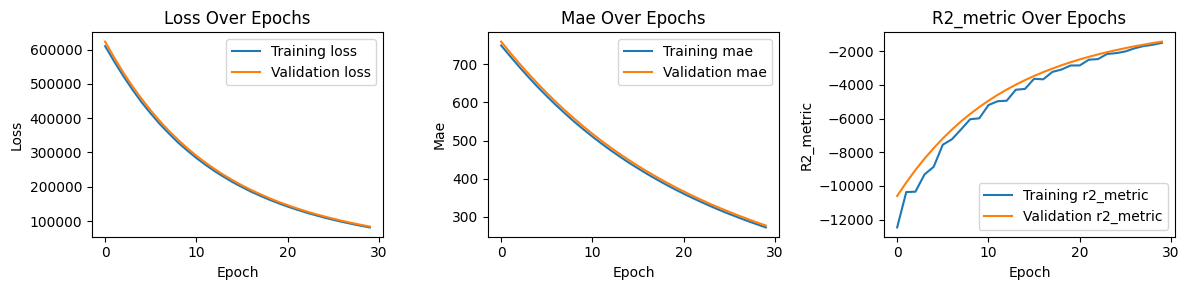

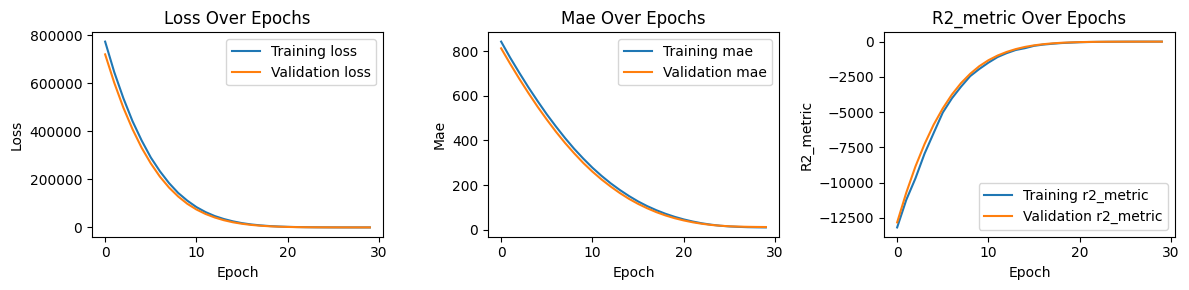

Final Metrics (Mean ± Std):
. loss: 16415.5968 ± 32532.8840
. mae: 62.3866 ± 104.9098
. r2_metric: -302.2296 ± 601.2808
. val_loss: 16930.0828 ± 33540.1939
. val_mae: 63.3655 ± 106.8937
. val_r2_metric: -287.6343 ± 571.2512


In [23]:
for neurons in neurons_choices:
    models, models_hist, final_metrics = train_kfold(dataset, neurons=neurons)

    for history in models_hist:
        history_dict = models_hist[history].history
        plot_metrics(history_dict)
    
    print("Final Metrics (Mean ± Std):")    
    for metric, values in final_metrics.items():
        mean = np.mean(values)
        std = np.std(values)
        print(f". {metric}: {mean:.4f} ± {std:.4f}")

## Test data

In [28]:
models

In [24]:
final_metrics['val_r2_metric']

[-0.9393148422241211,
 -3.114405632019043,
 -0.5219545960426331,
 -1430.1343994140625,
 -3.461653470993042]

In [25]:
metric = 'val_loss'

best_score = min(final_metrics[metric])
for idx, model in enumerate(models):
    if final_metrics[metric][idx] == best_score:
        best_score_idx = idx
print(best_score)
best_model = models[best_score_idx]
best_model

87.73081970214844


In [26]:
best_model.predict(X_test)

2/2 [==============================] - 0s 1ms/step


array([[33.505936],
       [27.46782 ],
       [20.109718],
       [31.226006],
       [16.973572],
       [23.198853],
       [15.673804],
       [26.266785],
       [11.372123],
       [27.373566],
       [26.591316],
       [25.875046],
       [23.762848],
       [28.32779 ],
       [28.344566],
       [23.512924],
       [15.868438],
       [25.995506],
       [23.6512  ],
       [24.293861],
       [24.12539 ],
       [26.760048],
       [30.738838],
       [23.109444],
       [18.156044],
       [24.744606],
       [33.769302],
       [21.349693],
       [24.930939],
       [26.362877],
       [32.334686],
       [11.810439],
       [24.713112],
       [19.803268],
       [34.030487]], dtype=float32)

In [27]:
y_test

0     25.0
1     24.0
2     23.0
3     23.0
4     15.0
5     14.0
6     18.0
7     11.0
8     18.0
9     24.0
10    25.0
11    31.0
12    18.0
13    15.0
14    24.0
15    15.5
16    14.5
17    24.0
18    31.5
19    30.5
20    20.2
21    20.8
22    23.8
23    31.5
24    35.7
25    38.1
26    24.3
27    32.7
28    37.0
29    37.7
30    29.9
31    26.6
32    38.0
33    32.0
34    31.0
Name: MPG, dtype: float64